# TP n°3 : Segmentation supervisée et non supervisée d’images grâce aux champs de Markov cachés 

In [17]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib import image
from PIL import Image
import cv2 as cv
from sklearn.cluster import KMeans
from scipy.integrate import quad 
import pandas as pd

## Partie 4 : Les champs de Markov : l’échantillonneur de Gibbs 

In [18]:
def affiche_image(titre,image):
    '''
        Comme son nom l'indique, cette fonction nous affiche l'image ainsi que son titre.
    '''
    plt.imshow(image, cmap='gray')
    plt.title(titre)
    plt.axis('off')
    plt.show()

In [56]:
def lit_image(chemin_image):
    '''
        Cette fonction nous renvoie:
            - la matrice de l'image en noir et blanc
            - son nombre m de lignes
            - son nombre n de colonnes
    '''
    img=cv.cvtColor(cv.imread(chemin_image),cv.COLOR_BGR2GRAY)
    return img,int(img.shape[0]),int(img.shape[1])

In [19]:
def calc_proba_champs(alpha,voisinage=4):
    '''
    Crée un np array de taille 5x2 avec
    proba[i, j] = p(x_s=j|"il y a i voisins de type j")
    '''
    return np.transpose(np.asarray([1/(1+np.exp(2*voisinage*alpha - voisinage*np.arange(0,voisinage+1)*alpha)),1-1/(1+np.exp(2*voisinage*alpha - voisinage*np.arange(0,voisinage+1)*alpha))]))


In [20]:
def calc_proba_champ(alpha, normalization=True, voisinage=4):
    '''
    crée un np array de taille 5x2 avec
    proba[i, j] = p(x_s=j|"il y a i voisins de type j")
    '''
    proba = np.empty((voisinage + 1, 2))
    for i in range(voisinage + 1):
        proba[i, 0] = np.exp((2 * i - voisinage) * alpha)
        proba[i, 1] = np.exp((2 * (voisinage - i) - voisinage) * alpha)
        if normalization:
            proba[i] /= np.sum(proba[i])
    return proba

In [21]:
def genere_Gibbs_proba(mm, nn, classe, proba, nb_iter, voisinage=4):
    '''
    génère un champ de Markov de taille mmxnn
    de classes et lois locales données à l'aide de
    l'échantillonneur de Gibbs
    '''
    # initialisation aléatoire de l'échantillonneur de Gibbs
    X = np.random.randint(0, 2, size=(mm, nn))
    X = (X == 0) * classe[0] + (X == 1) * classe[1]

    if voisinage == 4:
        table_voisins = [(0, -1), (-1, 0), (0, 1), (1, 0)]
    elif voisinage == 8:
        table_voisins = [(0, -1), (-1, 0), (0, 1), (1, 0), (-1, -1), (1, -1),
        (-1, 1), (1, 1)]

    # pour chaque itération de l'échantillonneur de Gibbs
    for k in range(nb_iter):
        print("Gibbs itération numéro", k)
        # pour chaque site
        for i in range(1, mm - 1):
            for j in range(1, nn - 1):
                # on récupère la configuration du voisinage
                # i.e. on compte le nombre de voisins à la classe 1
                config = 0
                for v in table_voisins:
                    config += (X[i + v[0], j + v[1]] == classe[0])
                distribution_locale = proba[config]
                # on met à jour le site avec un tirage selon la
                # distribution locale
                u = np.random.rand(1, 1)
                X[i, j] = ((u <= distribution_locale[0]) * classe[0] +
                    (u > distribution_locale[0]) * classe[1])

    return X


In [22]:
def redecoupe_image(X_in):
    '''
    enlève les bords de l'image qui ne peuvent pas être mis à jour avec
    l'échantillonneur de Gibbs
    '''
    return X_in[1:X_in.shape[0] - 1, 1:X_in.shape[1] - 1]

In [23]:
def images_de_champs(mm,nn,alpha,nb_iter,voisinage=4,classe=[0,255]):
    proba=calc_proba_champ(alpha,voisinage=4)
    Xtemp=genere_Gibbs_proba(mm, nn, classe, proba, nb_iter, voisinage=4)
    X=redecoupe_image(Xtemp)
    
    return X

Gibbs itération numéro 0
Gibbs itération numéro 1
Gibbs itération numéro 2
Gibbs itération numéro 3
Gibbs itération numéro 4


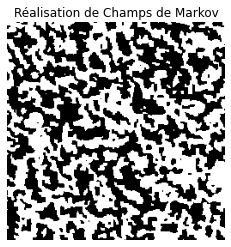

In [24]:
affiche_image('Réalisation de Champs de Markov',images_de_champs(256,256,2,5))

##  Partie 5 : Segmentation supervisée d’images grâce aux champs de Markov cachés 

In [33]:
def nouvelle_image(Y_in):
    '''
    Ajoute une nouvelle rangée de pixel autour de l'image bruitée pour pouvoir
    faire tourner l'échantillonneur de Gibbs sur tous les pixels d'intérêt
    '''
    return np.pad(Y_in, ((1, 1), (1, 1)), mode="edge")


def MPM_proba_gauss(Y, classe, m1, sig1, m2, sig2, proba, nb_iter,
    nb_simu, init_gibbs=None):
    '''
    Algorithme du calcul du MPM de Marroquin pour un champ de Markov caché à
    bruit gaussien indépendant
    '''
    X_MPM_stacked = np.zeros((Y.shape[0], Y.shape[1], nb_simu))
    # pour toutes les différentes simulations MPM
    for n in range(nb_simu):
        print("MPM itération numéro", n)
        X_MPM_stacked[..., n] = genere_Gibbs_proba_apost(Y, m1, sig1, m2, sig2,
        classe, proba, nb_iter, init_gibbs)

    # choix en chaque site de la classe la plus tirée lors des simulations MPM
    _cl0 = np.sum(X_MPM_stacked == classe[0], axis=-1)
    X_MPM = ((_cl0 >= nb_simu // 2) * classe[0] + (_cl0 < nb_simu // 2) *
    classe[1])
    return X_MPM

def genere_Gibbs_proba_apost(Y, m1, sig1, m2, sig2, classe, proba, nb_iter,
    init_gibbs=None):
    '''
    Échantillonneur de Gibbs pour le tirage a posteriori 'un champ de Markov
    caché à bruit gaussien indépendant
    '''
    if init_gibbs is None:
        # initialisation aléatoire de l'échantillonneur de Gibbs
        init_gibbs = np.random.randint(0, 2, size=Y.shape)
        init_gibbs = ((init_gibbs == 0) * classe[0] + (init_gibbs == 1) *
            classe[1])
    X = init_gibbs

    table_voisins = [(0, -1), (-1, 0), (0, 1), (1, 0)]

    # pour chaque itération de l'échantillonneur de Gibbs
    for k in range(nb_iter):
        print("Gibbs a posteriori itération numéro", k)
        # pour chaque site i.e s dans S hors de la bordure qui sert uniquement à ajouter des voisins pour Gibbs
        for i in range(1, Y.shape[0] - 1):
            for j in range(1, Y.shape[1] - 1):
                # on récupère la configuration du voisinage
                # i.e. on compte le nombre de voisins à la classe 1
                config = 0
                for v in table_voisins:
                    config += (X[i + v[0], j + v[1]] == classe[0])
                distribution_locale_apost = proba[config].copy() # copy ! 
                distribution_locale_apost[0] *= (1 / (np.sqrt(2 * np.pi) * sig1)
                    * np.exp(-0.5 * (Y[i, j] - m1) ** 2 / sig1 ** 2))
                distribution_locale_apost[1] *= (1 / (np.sqrt(2 * np.pi) * sig2)
                    * np.exp(-0.5 * (Y[i, j] - m2) ** 2 / sig2 ** 2))
                distribution_locale_apost /= np.sum(distribution_locale_apost)
                
                # on met à jour le site avec un tirage selon la
                # distribution locale a posteriori
                u = np.random.rand(1, 1)
                X[i, j] = ((u <= distribution_locale_apost[0]) * classe[0] +
                    (u > distribution_locale_apost[0]) * classe[1])

    return X


In [34]:
def bruit_gauss(X,m,n,cl1,cl2,m1,sig1,m2,sig2):
    Y = np.empty((m,n))
    Y[X==cl1]=sig1*np.random.randn(Y[X==cl1].shape[0])+m1
    Y[X==cl2]=sig2*np.random.randn(Y[X==cl2].shape[0])+m2
    return Y

In [35]:
def taux_erreur(A,B,m,n):
    """
        Retourne le taux d'erreur entre deux images A et B.
    """
    return np.count_nonzero(A!=B)/(m*n)

In [36]:
def champs_super(mm,nn,alpha,m1,sig1,m2,sig2,nb_iter,nb_simu,voisinage=4,classe=[0,255]):
    X = images_de_champs(mm+2,nn+2,alpha,nb_iter,voisinage=4,classe=[0,255])
    erreur = np.zeros(5)
    
    proba = calc_proba_champ(alpha, normalization=True, voisinage=4)
    Y = bruit_gauss(X,X.shape[0],X.shape[0],classe[0],classe[1],m1,sig1,m2,sig2)
    Ytrans = nouvelle_image(Y)

    for i in range(5):
        print("Calcul erreur itération "+str(i))
        X_predict = MPM_proba_gauss(Ytrans, classe, m1, sig1, m2, sig2, proba, nb_iter, nb_simu, init_gibbs=None)
        X_predict = redecoupe_image(X_predict)
        erreur[i]=taux_erreur(X,X_predict,mm,nn)

    fig, axes = plt.subplots(1,3, figsize=(10,4.5))
    axes[0].imshow(X, cmap='gray')
    axes[0].set_title('Image originale')
    axes[0].axis('off')
    axes[1].imshow(Ytrans, cmap='gray')
    axes[1].set_title('Image bruitée')
    axes[1].axis('off')
    axes[2].imshow(X_predict, cmap='gray')
    axes[2].set_title('Image segmentée')
    axes[2].axis('off')
    fig.suptitle('Réalisation de Champs de Markov bruitée avec $m_1$='+str(m1)+', $\sigma_1$='+str(sig1)+'; $m_2$='+str(m2)+', $\sigma_2$='+str(sig2)+"\n Taux d'erreur: "+str(np.mean(erreur)), fontsize=13)
    
    plt.show()
    
    return erreur

In [41]:
def calc_probapost_Gauss(Y,m,n,p1,p2,m1,sig1,m2,sig2):
    proba_apost = np.zeros((m,n,2))
    calc_apost1 = p1*norm.pdf(Y, m1, sig1)
    calc_apost2 = p2*norm.pdf(Y, m2, sig2)
    proba_apost[:,:,0] = calc_apost1 / (calc_apost1 + calc_apost2)
    proba_apost[:,:,1] = calc_apost2 / (calc_apost1 + calc_apost2)
    return proba_apost

def genere_Gibbs_proba_apost(Y, m1, sig1, m2, sig2, classe, proba, nb_iter, init_gibbs=None):
    '''
    Échantillonneur de Gibbs pour le tirage a posteriori 'un champ de Markov
    caché à bruit gaussien indépendant
    '''
    if init_gibbs is None:
        # initialisation aléatoire de l'échantillonneur de Gibbs
        init_gibbs = np.random.randint(0, 2, size=Y.shape)
        init_gibbs = ((init_gibbs == 0) * classe[0] + (init_gibbs == 1) *
            classe[1])
    X = init_gibbs

    table_voisins = [(0, -1), (-1, 0), (0, 1), (1, 0)]

    # pour chaque itération de l'échantillonneur de Gibbs
    for k in range(nb_iter):
        print("Gibbs a posteriori itération numéro", k)
        # pour chaque site
        for i in range(1, Y.shape[0] - 1):
            for j in range(1, Y.shape[1] - 1):
                # on récupère la configuration du voisinage
                # i.e. on compte le nombre de voisins à la classe 1
                config = 0
                for v in table_voisins:
                    config += (X[i + v[0], j + v[1]] == classe[0])
                distribution_locale_apost = proba[config].copy() # copy ! 
                distribution_locale_apost[0] *= (1 / (np.sqrt(2 * np.pi) * sig1)
                    * np.exp(-0.5 * (Y[i, j] - m1) ** 2 / sig1 ** 2))
                distribution_locale_apost[1] *= (1 / (np.sqrt(2 * np.pi) * sig2)
                    * np.exp(-0.5 * (Y[i, j] - m2) ** 2 / sig2 ** 2))
                distribution_locale_apost /= np.sum(distribution_locale_apost)
                
                # on met à jour le site avec un tirage selon la
                # distribution locale a posteriori
                u = np.random.rand(1, 1)
                X[i, j] = ((u <= distribution_locale_apost[0]) * classe[0] +
                    (u > distribution_locale_apost[0]) * classe[1])
    return X

def calc_N_part(X_simu, classe):
    '''
    Estimation des Nij apparaissant dans l'EM Gibbsien par une approche MCMC
    '''
    table_voisins = [(0, -1), (-1, 0), (0, 1), (1, 0)]
    N = np.zeros((5, 2))
    for i in range(1, X_simu.shape[0] - 1):
        for j in range(1, X_simu.shape[1] - 1):
            config = 0
            for v in table_voisins:
                config += (X_simu[i + v[0], j + v[1]] == classe[0])
            if X_simu[i, j] == classe[0]:
                N[config, 0] += 1
            else:
                N[config, 1] += 1
    return N
  
def calc_N_post(X_simu, classe):
    '''
    Estimation des probabilités a posteriori en chaque site par une approche
    MCMC
    '''
    N_post = np.stack([(X_simu == classe[0]), (X_simu == classe[1])], axis=-1) 
    return N_post

Gibbs itération numéro 0
Gibbs itération numéro 1
Gibbs itération numéro 2
Calcul erreur itération 0
MPM itération numéro 0
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
MPM itération numéro 1
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
MPM itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Calcul erreur itération 1
MPM itération numéro 0
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
MPM itération numéro 1
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
MPM itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Calcul erreur itération 2
MPM itération numéro 0
Gi

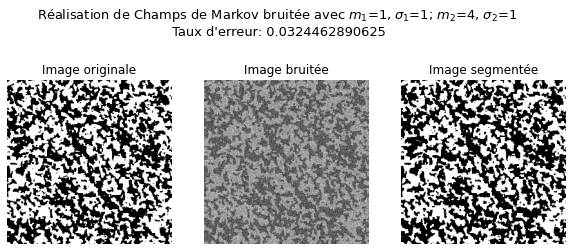

array([0.03216553, 0.03251648, 0.03269958, 0.03237915, 0.0324707 ])

In [37]:
m1=[1,1,1]
sig1=[1,1,1]
m2=[4,2,1]
sig2=[1,1,3]

champs_super(256,256,1,m1[0],sig1[0],m2[0],sig2[0],nb_iter=3,nb_simu=3)

Gibbs itération numéro 0
Gibbs itération numéro 1
Gibbs itération numéro 2
Gibbs itération numéro 3
Gibbs itération numéro 4
Calcul erreur itération 0
MPM itération numéro 0
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro 4
MPM itération numéro 1
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro 4
MPM itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro 4
MPM itération numéro 3
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro

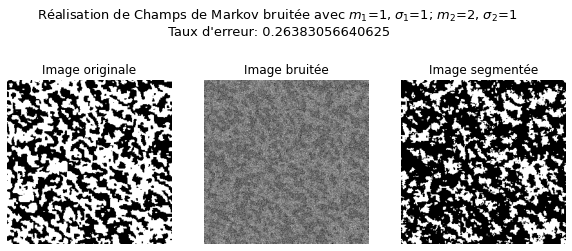

array([0.26573181, 0.26045227, 0.26448059, 0.2658844 , 0.26260376])

In [38]:
m1=[1,1,1]
sig1=[1,1,1]
m2=[4,2,1]
sig2=[1,1,3]

champs_super(256,256,1,m1[1],sig1[1],m2[1],sig2[1],nb_iter=5,nb_simu=5)

Gibbs itération numéro 0
Gibbs itération numéro 1
Gibbs itération numéro 2
Gibbs itération numéro 3
Gibbs itération numéro 4
Calcul erreur itération 0
MPM itération numéro 0
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro 4
MPM itération numéro 1
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro 4
MPM itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro 4
MPM itération numéro 3
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro

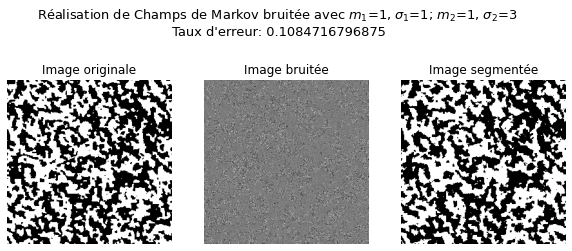

array([0.10986328, 0.10906982, 0.10914612, 0.10795593, 0.10632324])

In [39]:
m1=[1,1,1]
sig1=[1,1,1]
m2=[4,2,1]
sig2=[1,1,3]

champs_super(256,256,1,m1[2],sig1[2],m2[2],sig2[2],nb_iter=5,nb_simu=5)

In [109]:
def init_param_EM(Y,cl1,cl2,iter_KM):
    km = KMeans(n_clusters=2,n_init=iter_KM,random_state=0).fit(Y.reshape(-1,1))
    moyennes = km.cluster_centers_
    m,n = Y.shape[0], Y.shape[1]
    x_predict = km.labels_.reshape(m,n)
    x_predict[x_predict==np.argmax(moyennes)]=cl2
    x_predict[x_predict==np.argmin(moyennes)]=cl1
    X0= Y[x_predict==cl1]
    X1= Y[x_predict==cl2]

    n0 = X0.shape[0]
    n1 = X1.shape[0]     
    
    p10=(x_predict==cl1).sum()/(m*n)
    p20=(x_predict==cl2).sum()/(m*n)
    
    m10 = X0.sum()/(m*n)
    m20 = X1.sum()/(m*n)
    
    
    mom2 = np.array([(1/n0) * np.sum(X0**2), (1/n1) * np.sum(X1**2)])
    sigs = np.array([np.sqrt(mom2[0] - (1/n0)*m10), np.sqrt(mom2[1] - (1/n1)*m20)])
    
    sig10 = sigs[0]
    sig20 = sigs[1]
    
    return m10, sig10, m20, sig20

In [110]:
def EM_gibbsien_Gauss(Y,classe,m1,sig1,m2,sig2,proba,nb_iter_Gibbs__EM,nb_simu_EM):
    N_post_MCMC = np.zeros((Y.shape[0], Y.shape[1], classe.shape[0],nb_simu_EM))
    N_MCMC = np.zeros((5,2,nb_simu_EM))
    proba_new = np.zeros((5,2))
    Ppost = np.zeros((Y.shape[0], Y.shape[1], classe.shape[0]))
    
    for i in range(nb_simu_EM):
        X_simu = genere_Gibbs_proba_apost(Y,m1,sig1,m2,sig2,classe,proba,nb_iter_Gibbs_EM)
        N_MCMC[:,:,i] = calc_N_part(X_simu,classe)
        N_post_MCMC[:,:,:,i] = calc_N_post(X_simu,classe)
    
    for k in range(5):
        for l in range(2):
            proba_new[k,l] = np.sum(N_MCMC[k,l,:])/np.sum(N_MCMC[:,l,:])
    for k in range(Y.shape[0]):
        for l in range(Y.shape[1]):
            Ppost[k,l,0] = np.sum(N_post_MCMC[k,l,0,:])/np.sum(N_post_MCMC[k,l,:,:])
            Ppost[k,l,1] = np.sum(N_post_MCMC[k,l,1,:])/np.sum(N_post_MCMC[k,l,:,:])
    
    return proba_new, Ppost 

In [111]:
def estim_param_bruit_gauss_EM(Y,classe,Ppost): 
    mu = [0]*classe.shape[0]
    sigma = [0]*classe.shape[0]
    
    for i in range(classe.shape[0]):
        mu[i] = np.sum(Y * Ppost[:,:,i])/np.sum(Ppost[:,:,i])
        sigma[i] = np.sqrt(np.sum((Y-mu[i])**2 * Ppost[:,:,i])/np.sum(Ppost[:,:,i]))
        
    return mu[0], sigma[0], mu[1], sigma[1]

In [112]:
def EM_gauss(Y,classe,iter_KM, nb_iter_EM,nb_iter_Gibbs_EM,nb_simu_EM): 
    m1, sig1, m2, sig2 = init_param_EM(Y, classe[0], classe[1], iter_KM)
    proba = calc_proba_champs(alpha=1)
    
    for i in range(nb_iter_EM):
        proba, Ppost = EM_gibbsien_Gauss(Y,classe,m1,sig1,m2,sig2,proba,nb_iter_Gibbs_EM,nb_simu_EM) 
    mu1, sigma1, mu2, sigma2 = estim_param_bruit_gauss_EM(Y, classe, Ppost)
    return proba,mu1, sigma1, mu2, sigma2

In [132]:
def champs_non_super(chemin_image,m1,sig1,m2,sig2,nb_iter_Gibbs_EM,nb_simu_EM,voisinage=4,classe=[0,255]):
    X, mm, nn = lit_image(chemin_image)
    alpha = 1 
    iter_KM = 20
    nb_iter_EM = 10
    Y = bruit_gauss(X,X.shape[0],X.shape[0],classe[0],classe[1],m1,sig1,m2,sig2) 
    Ytrans = nouvelle_image(Y)
    
    # Initialisation 
    proba_est, m1_est, sig1_est, m2_est, sig2_est = EM_gauss(Y, classe, iter_KM, nb_iter_EM, nb_iter_Gibbs_EM, nb_simu_EM)
    

    X_predict = MPM_proba_gauss(Ytrans, classe, m1, sig1, m2, sig2, proba_est, nb_iter_Gibbs_EM, nb_simu_EM, init_gibbs=None)
    X_predict = redecoupe_image(X_predict)
    erreur = taux_erreur(X, X_predict, mm, nn)
    fig, axes = plt.subplots(1,3, figsize=(10,4.5))
    axes[0].imshow(X, cmap='gray')
    axes[0].set_title('Image originale')
    axes[0].axis('off')
    axes[1].imshow(Ytrans, cmap='gray')
    axes[1].set_title('Image bruitée')
    axes[1].axis('off')
    axes[2].imshow(X_predict, cmap='gray')
    axes[2].set_title('Image segmentée')
    axes[2].axis('off')
    fig.suptitle('Réalisation de Champs de Markov bruitée avec $m_1$='+str(m1)+', $\sigma_1$='+str(sig1)+'; $m_2$='+str(m2)+', $\sigma_2$='+str(sig2)+"\n Taux d'erreur: "+str(erreur), fontsize=13)
    
    plt.show()
    
    return erreur

Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a post

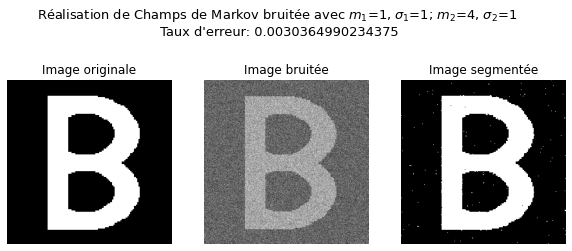

0.0030364990234375

In [116]:
m1=[1,1,1]
sig1=[1,1,1]
m2=[4,2,1]
sig2=[1,1,3]
chemin_image = './images/beee2.bmp'
nb_iter_Gibbs_EM = 3 
nb_simu_EM = 10


champs_non_super(chemin_image,m1[0],sig1[0],m2[0],sig2[0],nb_iter_Gibbs_EM,nb_simu_EM,classe=np.array([0,255]))

In [ ]:
m1=[1,1,1]
sig1=[1,1,1]
m2=[4,2,1]
sig2=[1,1,3]
chemin_image = './images/beee2.bmp'
nb_iter_Gibbs_EM = 7 
nb_simu_EM = 10


champs_non_super(chemin_image,m1[1],sig1[1],m2[1],sig2[1],nb_iter_Gibbs_EM,nb_simu_EM,classe=np.array([0,255]))

In [ ]:
m1=[1,1,1]
sig1=[1,1,1]
m2=[4,2,1]
sig2=[1,1,3]
chemin_image = './images/beee2.bmp'
nb_iter_Gibbs_EM = 7 
nb_simu_EM = 10


champs_non_super(chemin_image,m1[2],sig1[2],m2[2],sig2[2],nb_iter_Gibbs_EM,nb_simu_EM,classe=np.array([0,255]))

Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a post

Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0


/Users/lorenzohermez/opt/anaconda3/envs/MNIST/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a post

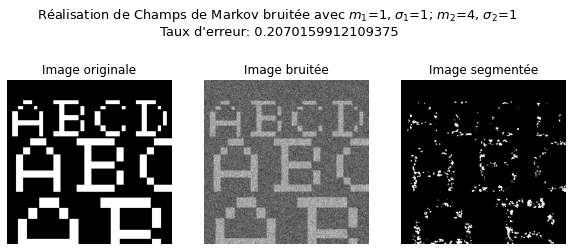

0.2070159912109375

In [138]:
m1=[1,1,1]
sig1=[1,1,1]
m2=[4,2,1]
sig2=[1,1,3]
chemin_image = './images/alfa2.bmp'
nb_iter_Gibbs_EM = 3 
nb_simu_EM = 10


champs_non_super(chemin_image,m1[0],sig1[0],m2[0],sig2[0],nb_iter_Gibbs_EM,nb_simu_EM,classe=np.array([0,255]))

In [ ]:
m1=[1,1,1]
sig1=[1,1,1]
m2=[4,2,1]
sig2=[1,1,3]
chemin_image = './images/alfa2.bmp'
nb_iter_Gibbs_EM = 7 
nb_simu_EM = 10


champs_non_super(chemin_image,m1[1],sig1[1],m2[1],sig2[1],nb_iter_Gibbs_EM,nb_simu_EM,classe=np.array([0,255]))

In [ ]:
m1=[1,1,1]
sig1=[1,1,1]
m2=[4,2,1]
sig2=[1,1,3]
chemin_image = './images/alfa2.bmp'
nb_iter_Gibbs_EM = 7 
nb_simu_EM = 10


champs_non_super(chemin_image,m1[2],sig1[2],m2[2],sig2[2],nb_iter_Gibbs_EM,nb_simu_EM,classe=np.array([0,255]))

Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a post

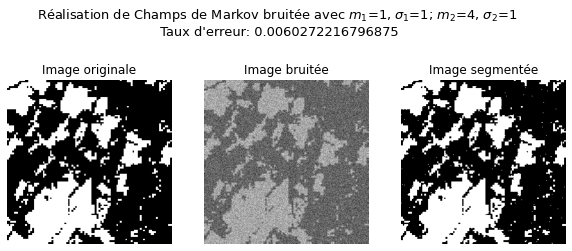

0.0060272216796875

In [123]:
m1=[1,1,1]
sig1=[1,1,1]
m2=[4,2,1]
sig2=[1,1,3]
chemin_image = './images/country2.bmp'
nb_iter_Gibbs_EM = 3 
nb_simu_EM = 10


champs_non_super(chemin_image,m1[0],sig1[0],m2[0],sig2[0],nb_iter_Gibbs_EM,nb_simu_EM,classe=np.array([0,255]))

In [ ]:
m1=[1,1,1]
sig1=[1,1,1]
m2=[4,2,1]
sig2=[1,1,3]
chemin_image = './images/country2.bmp'
nb_iter_Gibbs_EM = 7 
nb_simu_EM = 10


champs_non_super(chemin_image,m1[1],sig1[1],m2[1],sig2[1],nb_iter_Gibbs_EM,nb_simu_EM,classe=np.array([0,255]))

In [ ]:
m1=[1,1,1]
sig1=[1,1,1]
m2=[4,2,1]
sig2=[1,1,3]
chemin_image = './images/country2.bmp'
nb_iter_Gibbs_EM = 7 
nb_simu_EM = 10


champs_non_super(chemin_image,m1[2],sig1[2],m2[2],sig2[2],nb_iter_Gibbs_EM,nb_simu_EM,classe=np.array([0,255]))

Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a post

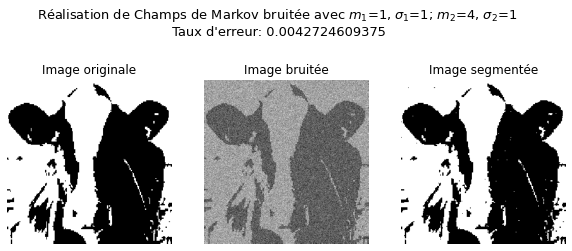

0.0042724609375

In [126]:
m1=[1,1,1]
sig1=[1,1,1]
m2=[4,2,1]
sig2=[1,1,3]
chemin_image = './images/veau2.bmp'
nb_iter_Gibbs_EM = 3 
nb_simu_EM = 10


champs_non_super(chemin_image,m1[0],sig1[0],m2[0],sig2[0],nb_iter_Gibbs_EM,nb_simu_EM,classe=np.array([0,255]))

Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a post

/Users/lorenzohermez/opt/anaconda3/envs/MNIST/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
MPM itération numéro 1
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
MPM itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
MPM itération numéro 3
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
MPM itération numéro 4
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
MPM itération numéro 5
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
MPM itération numéro 6
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
MPM itération numéro 7
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gib

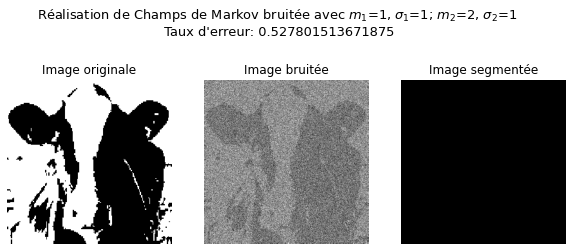

0.527801513671875

In [127]:
m1=[1,1,1]
sig1=[1,1,1]
m2=[4,2,1]
sig2=[1,1,3]
chemin_image = './images/veau2.bmp'
nb_iter_Gibbs_EM = 3 
nb_simu_EM = 10


champs_non_super(chemin_image,m1[1],sig1[1],m2[1],sig2[1],nb_iter_Gibbs_EM,nb_simu_EM,classe=np.array([0,255]))

Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a post

Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a post

/Users/lorenzohermez/opt/anaconda3/envs/MNIST/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a post

Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a post

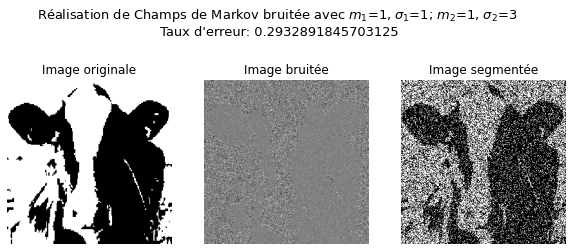

0.2932891845703125

In [137]:
m1=[1,1,1]
sig1=[1,1,1]
m2=[4,2,1]
sig2=[1,1,3]
chemin_image = './images/veau2.bmp'
nb_iter_Gibbs_EM = 3
nb_simu_EM = 20


champs_non_super(chemin_image,m1[2],sig1[2],m2[2],sig2[2],nb_iter_Gibbs_EM,nb_simu_EM,classe=np.array([0,255]))

Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro 4
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro 4
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro 4
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro 4
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro 4
Gibbs a posteriori itération numéro 0
Gibbs a post

Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro 4
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro 4
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro 4
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro 4
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro 4
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a post

/Users/lorenzohermez/opt/anaconda3/envs/MNIST/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro 4
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro 4
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro 4
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro 4
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro 4
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a post

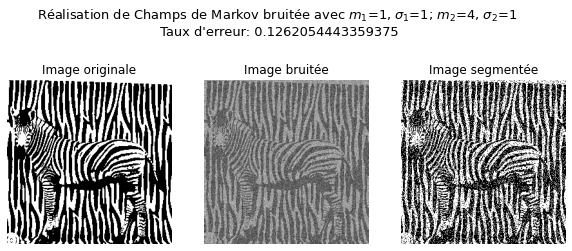

0.1262054443359375

In [134]:
m1=[1,1,1]
sig1=[1,1,1]
m2=[4,2,1]
sig2=[1,1,3]
chemin_image = './images/zebre2.bmp'
nb_iter_Gibbs_EM = 5 
nb_simu_EM = 10


champs_non_super(chemin_image,m1[0],sig1[0],m2[0],sig2[0],nb_iter_Gibbs_EM,nb_simu_EM,classe=np.array([0,255]))

Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro 4
Gibbs a posteriori itération numéro 5
Gibbs a posteriori itération numéro 6
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro 4
Gibbs a posteriori itération numéro 5
Gibbs a posteriori itération numéro 6
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro 4
Gibbs a posteriori itération numéro 5
Gibbs a posteriori itération numéro 6
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro 4
Gibbs a post

/Users/lorenzohermez/opt/anaconda3/envs/MNIST/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro 4
Gibbs a posteriori itération numéro 5
Gibbs a posteriori itération numéro 6
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro 4
Gibbs a posteriori itération numéro 5
Gibbs a posteriori itération numéro 6
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro 4
Gibbs a posteriori itération numéro 5
Gibbs a posteriori itération numéro 6
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro 4
Gibbs a posteriori itération numéro 5
Gibbs a post

Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro 4
Gibbs a posteriori itération numéro 5
Gibbs a posteriori itération numéro 6
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro 4
Gibbs a posteriori itération numéro 5
Gibbs a posteriori itération numéro 6
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro 4
Gibbs a posteriori itération numéro 5
Gibbs a posteriori itération numéro 6
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro 4
Gibbs a post

Gibbs a posteriori itération numéro 6
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro 4
Gibbs a posteriori itération numéro 5
Gibbs a posteriori itération numéro 6
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro 4
Gibbs a posteriori itération numéro 5
Gibbs a posteriori itération numéro 6
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro 4
Gibbs a posteriori itération numéro 5
Gibbs a posteriori itération numéro 6
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a post

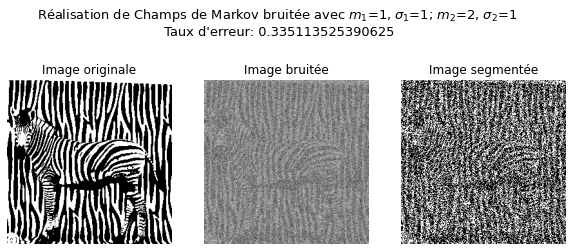

0.335113525390625

In [133]:
m1=[1,1,1]
sig1=[1,1,1]
m2=[4,2,1]
sig2=[1,1,3]
chemin_image = './images/zebre2.bmp'
nb_iter_Gibbs_EM = 7 
nb_simu_EM = 10


champs_non_super(chemin_image,m1[1],sig1[1],m2[1],sig2[1],nb_iter_Gibbs_EM,nb_simu_EM,classe=np.array([0,255]))

Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro 4
Gibbs a posteriori itération numéro 5
Gibbs a posteriori itération numéro 6
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro 4
Gibbs a posteriori itération numéro 5
Gibbs a posteriori itération numéro 6
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro 4
Gibbs a posteriori itération numéro 5
Gibbs a posteriori itération numéro 6
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro 4
Gibbs a post

/Users/lorenzohermez/opt/anaconda3/envs/MNIST/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro 4
Gibbs a posteriori itération numéro 5
Gibbs a posteriori itération numéro 6
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro 4
Gibbs a posteriori itération numéro 5
Gibbs a posteriori itération numéro 6
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro 4
Gibbs a posteriori itération numéro 5
Gibbs a posteriori itération numéro 6
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro 4
Gibbs a posteriori itération numéro 5
Gibbs a post

/Users/lorenzohermez/opt/anaconda3/envs/MNIST/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro 4
Gibbs a posteriori itération numéro 5
Gibbs a posteriori itération numéro 6
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro 4
Gibbs a posteriori itération numéro 5
Gibbs a posteriori itération numéro 6
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro 4
Gibbs a posteriori itération numéro 5
Gibbs a posteriori itération numéro 6
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro 4
Gibbs a post

Gibbs a posteriori itération numéro 6
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro 4
Gibbs a posteriori itération numéro 5
Gibbs a posteriori itération numéro 6
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro 4
Gibbs a posteriori itération numéro 5
Gibbs a posteriori itération numéro 6
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro 4
Gibbs a posteriori itération numéro 5
Gibbs a posteriori itération numéro 6
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a post

Gibbs a posteriori itération numéro 4
Gibbs a posteriori itération numéro 5
Gibbs a posteriori itération numéro 6
MPM itération numéro 2
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro 4
Gibbs a posteriori itération numéro 5
Gibbs a posteriori itération numéro 6
MPM itération numéro 3
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro 4
Gibbs a posteriori itération numéro 5
Gibbs a posteriori itération numéro 6
MPM itération numéro 4
Gibbs a posteriori itération numéro 0
Gibbs a posteriori itération numéro 1
Gibbs a posteriori itération numéro 2
Gibbs a posteriori itération numéro 3
Gibbs a posteriori itération numéro 4
Gibbs a posteriori itération numéro 5
Gibbs a posteriori itération numéro 6
MPM itération numér

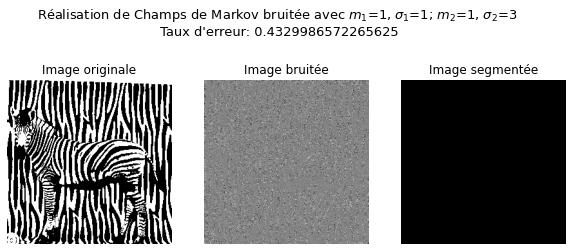

0.4329986572265625

In [135]:
m1=[1,1,1]
sig1=[1,1,1]
m2=[4,2,1]
sig2=[1,1,3]
chemin_image = './images/zebre2.bmp'
nb_iter_Gibbs_EM = 7 
nb_simu_EM = 10


champs_non_super(chemin_image,m1[2],sig1[2],m2[2],sig2[2],nb_iter_Gibbs_EM,nb_simu_EM,classe=np.array([0,255]))

Partie 5: On veut faire un MPM avec un champs de Markov 

$\mathbb{P}(x,y) = \frac{1}{2}e^{\underset{c\in\mathcal{C}}{\sum}\phi_c(x_c) + \underset{s\in S}{\sum}log p(y_s|x_s)}$

V ) On simule N fois selon $\mathbb{P}(x|y)$. On regarde pour chaque x_s et on prend la classe qui revient le plus souvent (celle dont l'occurence est supérieure à $\frac{N}{2}$)